## Python-gmt Test with FOCI Data from ERDDAP
### erddapy example for PMEL tools - ARGO Floats

__pyversion__==3.7   
__author__==S.Bell

### connecting and basic information

In [1]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url='http://downdraft.pmel.noaa.gov:8080/erddap'
e = ERDDAP(server=server_url)

Get only ARGOS Drifter datafiles

In [2]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='argos'))

In [3]:
argos = df['Dataset ID'].values
print(argos)

['2015_Argos_Drifters_NRT' '2016_Argos_Drifters_NRT'
 '2017_Argos_Drifters_NRT' '2018_Argos_Drifters_NRT'
 '2019_Argos_Drifters_NRT']


In [18]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': 0,
    'max_lon': 540,
    'min_lat': 66.0,
    'max_lat': 90.0,
    'min_time': '2015-01-10T00:00:00Z',
    'max_time': '2020-01-10T00:00:00Z',
    'cdm_data_type': 'trajectory'
}

In [19]:
variables = [e.get_var_by_attr(dataset_id=float, long_name=lambda v: v is not None) for float in argos]

In [20]:
common_variables = set(variables[0]).intersection(*variables[1:])

common_variables.update(['trajectory_id']) 
common_variables

{'latitude', 'longitude', 'sst', 'strain', 'time', 'trajectory_id', 'voltage'}

In [21]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

download_url = e.get_download_url(
    dataset_id=argos[0],
    protocol='tabledap',
    response='csv',
    variables=common_variables,
    constraints=constraints
)

print(download_url)



http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/2015_Argos_Drifters_NRT.csv?trajectory_id,strain,longitude,sst,latitude,time,voltage&longitude>=0&longitude<=540&latitude>=66.0&latitude<=90.0&time>=1420848000.0&time<=1578614400.0


In [22]:
from requests.exceptions import HTTPError

dfs = {}
for arfloat in argos:
    print(arfloat)
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.constraints=constraints
        e.variables=common_variables
        e.dataset_id=arfloat
    except HTTPError:
        print('Failed to generate url {}'.format(alamo))
        continue
    try:
        
        df = e.to_pandas(
            index_col='time (UTC)',
            parse_dates=True,
            skiprows=(1,)  # units information can be dropped.
        ).dropna()

        df.sort_index(inplace=True)
        df.columns = [x[1].split()[0] for x in enumerate(df.columns)]

        dfs.update({arfloat: df})
        
    except:
        print(f"Didn't Load {arfloat}")


2015_Argos_Drifters_NRT
2016_Argos_Drifters_NRT
2017_Argos_Drifters_NRT
2018_Argos_Drifters_NRT
2019_Argos_Drifters_NRT
Didn't Load 2019_Argos_Drifters_NRT


In [23]:
for float, df in dfs.items():
    print(float, df.groupby('trajectory_id').groups.keys())

2015_Argos_Drifters_NRT dict_keys([122847, 136859, 136860, 136861, 136862, 136863, 136864, 136865, 136866, 136867, 136868, 136869, 136870])
2016_Argos_Drifters_NRT dict_keys([136861, 136864, 136865, 136872])
2017_Argos_Drifters_NRT dict_keys([122537, 122540, 122541, 122542, 136868, 136869, 136872, 148277])
2018_Argos_Drifters_NRT dict_keys([136868, 139910, 139911, 139912, 139913, 139914, 139915])


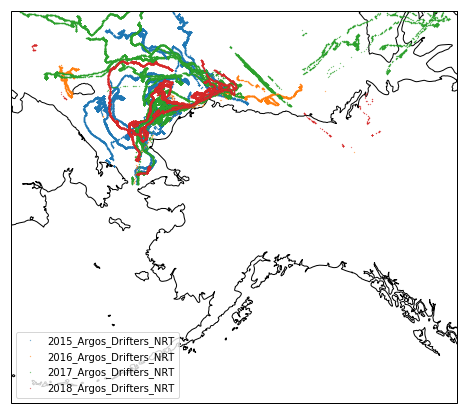

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 8),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
extent = -180, -130, kw['min_lat']+dy, kw['max_lat']+dy
extent = [-180, -130, 50, 75]
fig,ax = make_map(projection=projection)
for float, df in dfs.items():
    try:
        ax.plot(df['longitude'], df['latitude'], '.', markersize=0.5, label=float, transform=transformation)
    except:
        ax.plot(df['lon'], df['lat'], '.', markersize=0.5, label=float, transform=transformation)
        
leg = ax.legend()

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)